# Garbage classification system project

For this project, our team develop/implement/code the garbage classification model.

## Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
import matplotlib.pylab as plt
import pickle
from skimage import transform # pip install scikit-image
import time
from datetime import datetime
from datetime import timedelta

## 1. Load dataset, explore it (display images, mean, min, max values, etc.)

### 1.1 Define the paths

In [2]:
f_path_train = "C:\work_2021\deepLearning\Garbage-dataset\Train"   #File path to developmemt set
f_path_validation = "C:\work_2021\deepLearning\Garbage-dataset\Validation"
f_path_test = "C:\work_2021\deepLearning\Garbage-dataset\Test"

### 1.2 Exploring our data

There are 4 classes in the dataset, that represents the trash bin an object should be disposed of.

In [3]:
#Printing number and types of category
categories = os.listdir(f_path_train)
for directory in categories:
    if directory == ".DS_Store":
        categories.remove(directory) # remove .DS_Store from list
    else:
        pass
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Black', 'Blue', 'Green', 'Take-to-recycle'] 

No. of categories =  4


In [4]:
class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]
images_train = np.asarray(glob.glob(f_path_train + "/*/*.png"))
labels_train = np.asarray([f.split("\\")[-2] for f in images_train])
print("\nTrain Images")
print("Images shape = ",images_train.shape,"\nLabels shape = ",labels_train.shape)
print(len(images_train))
print(images_train[:4])
print(labels_train[:4])


Train Images
Images shape =  (5139,) 
Labels shape =  (5139,)
5139
['C:\\work_2021\\deepLearning\\Garbage-dataset\\Train\\Black\\black_0000220.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Train\\Black\\black_0000221.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Train\\Black\\black_0000222.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Train\\Black\\black_0000223.png']
['Black' 'Black' 'Black' 'Black']


In [5]:
class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]
images_val = np.asarray(glob.glob(f_path_validation + "/*/*.png"))
labels_val = np.asarray([f.split("\\")[-2] for f in images_val])
print("\nValidation Images")
print("Images shape = ",images_val.shape,"\nLabels shape = ",labels_val.shape)
print(len(images_val))
print(images_val[:4])
print(labels_val[:4])


Validation Images
Images shape =  (1123,) 
Labels shape =  (1123,)
1123
['C:\\work_2021\\deepLearning\\Garbage-dataset\\Validation\\Black\\black_0001495.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Validation\\Black\\black_0001496.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Validation\\Black\\black_0001497.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Validation\\Black\\black_0001498.png']
['Black' 'Black' 'Black' 'Black']


In [6]:
class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]
images_test = np.asarray(glob.glob(f_path_test + "/*/*.png"))
labels_test = np.asarray([f.split("\\")[-2] for f in images_test])
print("\nTest Images")
print("Images shape = ",images_test.shape,"\nLabels shape = ",labels_test.shape)
print(len(images_test))
print(images_test[:4])
print(labels_test[:4])


Test Images
Images shape =  (629,) 
Labels shape =  (629,)
629
['C:\\work_2021\\deepLearning\\Garbage-dataset\\Test\\Black\\black_0000001.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Test\\Black\\black_0000002.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Test\\Black\\black_0000003.png'
 'C:\\work_2021\\deepLearning\\Garbage-dataset\\Test\\Black\\black_0000004.png']
['Black' 'Black' 'Black' 'Black']


In [7]:
# Representing class names as integers 
Y = np.zeros(len(labels_train))
for ii in range(len(class_names)):
    Y[labels_train == class_names[ii]] =  ii

In [8]:
# Dimensions we will resize the images
img_height = 256
img_width = 256

X = np.zeros((len(images_train),img_height,img_width,3))
for (ii,img) in enumerate(images_train):
    X[ii] = transform.resize(plt.imread(img),(img_height,img_width,3))

### 1.3 Data display

Below some samples from the development set has been displayed

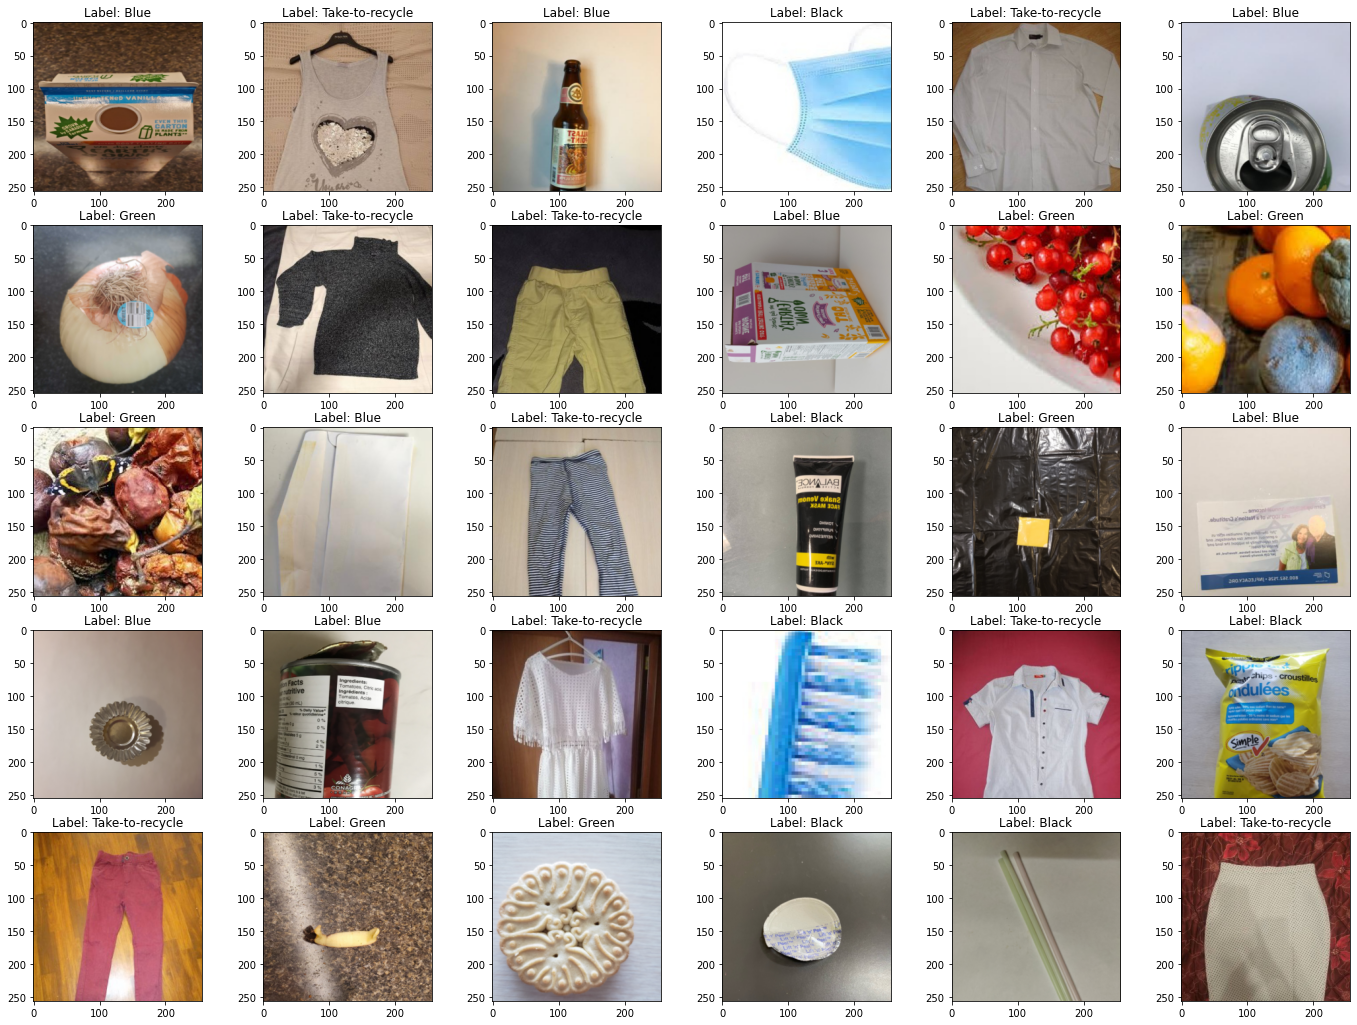

In [9]:
sample_indexes = np.random.choice(np.arange(X.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X[jj], cmap = "gray")
    plt.title("Label: %s" %class_names[int(Y[jj])])
plt.show()

In [10]:
print("Shape of Train Set Array: ",X.shape)
print("Shape of Label Set Array: ",Y.shape)
# The data seems to be already scaled between 0 and 1, so we do nothing
print(X.min(),X.max(),X.mean(),X.std())

Shape of Train Set Array:  (5139, 256, 256, 3)
Shape of Label Set Array:  (5139,)
0.0 1.0 0.6303849327059141 0.28117949500243633


## 2. Data import and augmentation

In [11]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

#### 2.1 Training data

In [12]:
bs = 64 # batch size

In [13]:
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

train_generator = train_gen.flow_from_directory(
    directory = "C:\\work_2021\\deepLearning\\Garbage-dataset\\Train",
    # directory = "/work/TALC/enel645_2022w/Garbage-dataset/Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 5141 images belonging to 4 classes.


In [14]:
# show augmented images
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 5, figsize=(20, 20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img)
#     plt.tight_layout()
#     plt.show()

In [15]:
# showing augmented images
# images = [train_generator[0][0][0] for i in range(5)]
# plotImages(images)

#### 2.2 Validation data 

In [16]:
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

validation_generator = val_gen.flow_from_directory(
    directory = "C:\\work_2021\\deepLearning\\Garbage-dataset\\Validation",
    # directory = "/work/TALC/enel645_2022w/Garbage-dataset/Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 1123 images belonging to 4 classes.


#### 2.3 Test data 

In [17]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "C:\\work_2021\\deepLearning\\Garbage-dataset\\Test",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


### 2.4 Class distribution
For having a better undrestanding of the classes, we analyze how many samples of each garbage are available. The histogram of the classes visualize this distribution.

In [18]:
from collections import Counter
train = Counter(train_generator.classes)
val = Counter(validation_generator.classes)
test = Counter(test_generator.classes)
total = dict(train+val+test)
class_names = dict(train_generator.class_indices)
class_names = {v: k for k, v in class_names.items()}

In [19]:
class_df = pd.DataFrame([class_names,total]).transpose()
class_df.columns=['Garbage','Image Numbers']
print('Total number of images in train, validation and test folders:')
class_df

Total number of images in train, validation and test folders:


,Garbage,Image Numbers
0,Black,1765
1,Blue,1814
2,Green,1814
3,Take-to-recycle,1678


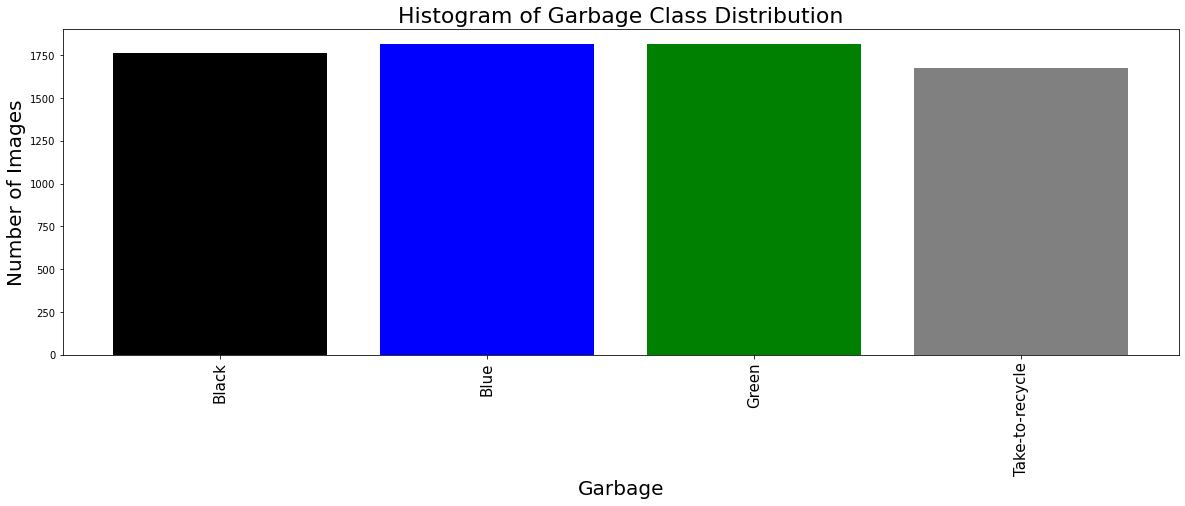

In [20]:
fig = plt.figure()
fig.set_size_inches(20,6)
plt.bar(class_df['Garbage'],class_df['Image Numbers'], color=['black', 'blue','green','gray'])
plt.xticks(rotation=90,fontsize=15)
plt.xlabel("Garbage", fontsize=20)
plt.ylabel("Number of Images", fontsize=20)
plt.title("Histogram of Garbage Class Distribution", fontsize=22)
plt.show()

### 2.5 Training image analysis

In [21]:
  h, w, r = train_generator.image_shape
  print('There are', train_generator.samples, 'images for training the model')
  print("Approximately {:.0f} images per category".format(train_generator.samples/train_generator.num_classes))
  print('The shape of each image is', train_generator.image_shape)
  print('From which:')
  print('The width is', w)
  print('The height is', h)
  print('And each pixel has a value for each component of RGB for a total of', r)

There are 5141 images for training the model
Approximately 1285 images per category
The shape of each image is (256, 256, 3)
From which:
The width is 256
The height is 256
And each pixel has a value for each component of RGB for a total of 3


## 3. Define the callbacks for VGG19 model

In [22]:
model_name_it = "garbage_classifier_vgg19_it.h5"
model_name_ft = "garbage_classifier_vgg19_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 4. Transfer Learning

- Choose and load the pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

- Freeze the layers (i.e., make them non-trainable) of your pretrained model

- Add a top (i.e., the prediction layers)

In [23]:
img_height = 256
img_width = 256

# Defining the model
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False #Using it to Freeze the layers of the pre-trained model

x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)

out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 4)                 131076    
                                                                 
Total params: 20,155,460
Trainable params: 131,076
Non-trainable params: 20,024,384
_________________________________________________________________
None


## 4.1 Train the model using dataset

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from datetime import timedelta
start_time = time.time()
history_it = model.fit(train_generator, epochs=10, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

end_time = time.time()
total_training_time = int(end_time - start_time)

Epoch 1/10
81/81 [==============================] - 863s 11s/step - loss: 3.0353 - accuracy: 0.6308 - val_loss: 2.9459 - val_accuracy: 0.6696 - lr: 1.0000e-04
Epoch 2/10
81/81 [==============================] - 862s 11s/step - loss: 1.7524 - accuracy: 0.7674 - val_loss: 2.5156 - val_accuracy: 0.7061 - lr: 1.0000e-04
Epoch 3/10
81/81 [==============================] - 869s 11s/step - loss: 1.4654 - accuracy: 0.7895 - val_loss: 2.3086 - val_accuracy: 0.7248 - lr: 1.0000e-04
Epoch 4/10
81/81 [==============================] - 881s 11s/step - loss: 1.2877 - accuracy: 0.8096 - val_loss: 2.0582 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 5/10
81/81 [==============================] - 868s 11s/step - loss: 1.1523 - accuracy: 0.8218 - val_loss: 2.0549 - val_accuracy: 0.7373 - lr: 1.0000e-04
Epoch 6/10
81/81 [==============================] - 872s 11s/step - loss: 1.0528 - accuracy: 0.8314 - val_loss: 2.2148 - val_accuracy: 0.7462 - lr: 1.0000e-04
Epoch 7/10
81/81 [============================

## 4.2 Plotting the initial model history

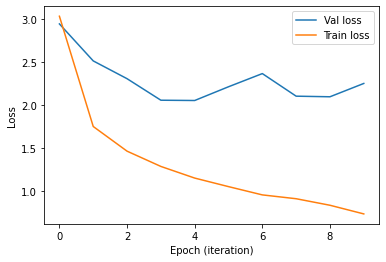

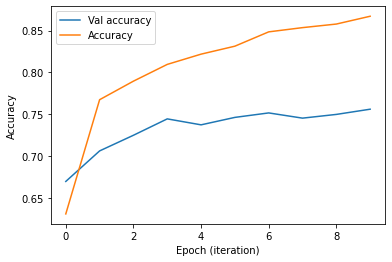

In [25]:
it_file = open("it_history.pkl", "wb")
pickle.dump(history_it.history, it_file)
it_file.close()

plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



## 4.3 Fine-tuning the model

In [26]:
model = tf.keras.models.load_model(model_name_it)
model.trainable = True  # Now we are training the parameters of the pre-trained model

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 4)                 131076    
                                                                 
Total params: 20,155,460
Trainable params: 20,155,460
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 2709s 33s/step - loss: 1.0145 - accuracy: 0.8372 - val_loss: 2.4268 - val_accuracy: 0.7266 - lr: 1.0000e-08

## 4.4 Plotting the fine-tuned model 

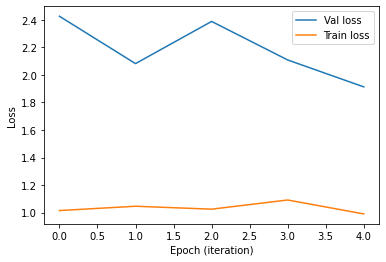

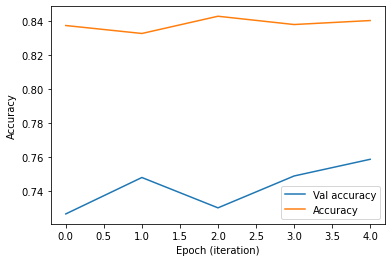

In [27]:
plt.figure()
plt.plot(history_ft.history["val_loss"], label = "Val loss")
plt.plot(history_ft.history["loss"], label = "Train loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ft.history["accuracy"], label = "Accuracy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

ft_file = open("ft_history.pkl", "wb")
pickle.dump(history_ft.history, ft_file)
it_file.close()

## 5. Test the model using test set and extract relevant metrics

## 5.1 Testing the model after initial training

In [28]:
model = tf.keras.models.load_model(model_name_it)
metrics = model.evaluate(test_generator)
print("Categorical cross-entropy:", round(metrics[0], 3))
print("Accuracy:", round(metrics[1]*100, 2),'%')

13/13 [==============================] - 114s 9s/step - loss: 2.1148 - accuracy: 0.7088
Categorical cross-entropy: 2.115
Accuracy: 70.88 %


## 5.2 Testing the model after fine tuning

In [29]:
model = tf.keras.models.load_model(model_name_ft)
metrics = model.evaluate(test_generator)

print("Categorical cross-entropy:", round(metrics[0], 3))
print("Accuracy:", round(metrics[1]*100, 2),'%')

13/13 [==============================] - 114s 9s/step - loss: 2.4721 - accuracy: 0.6853
Categorical cross-entropy: 2.472
Accuracy: 68.53 %


## 5.3 Displying wrongly classified images

Number of wrong predictions:  20


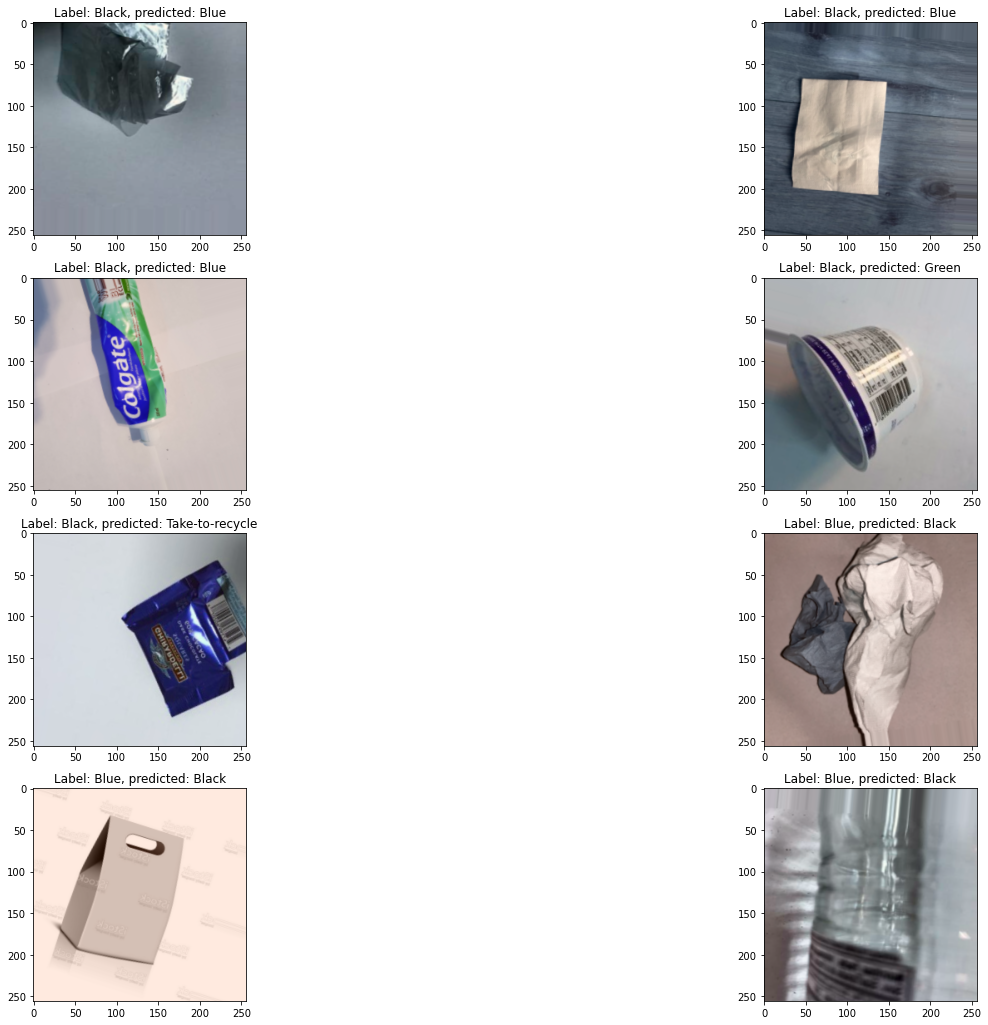

In [30]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]
print("Number of wrong predictions: ", len(wrong_indexes))

sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

## 5.4 Classification Report and Confusion Matrix

## 5.4.1 Function definitions

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

In [32]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [33]:
# report = classification_report(Ytest, Ypred, target_names=class_names)
# print(report)

# print classification report using default threshold
# print(classification_report(Ytest, Ypred))

predictions_test = model.predict(test_generator)
y_pred = np.argmax(predictions_test, axis=1)
y_true = test_generator.classes

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.30      0.26      0.28       215
           1       0.28      0.36      0.31       208
           2       0.22      0.21      0.22       206
           3       0.24      0.21      0.23       178

    accuracy                           0.26       807
   macro avg       0.26      0.26      0.26       807
weighted avg       0.26      0.26      0.26       807



In [34]:
# def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
#     '''Creates a heatmap plot of the confusion matrix.
    
#         y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
#         y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
#         labels (list(str)): Class names used for plotting (ticklabels)
#         title (str): Plot title
        
#         uses sklearn.metrics.confusion_matrix
        
#     '''
    
#     mat = confusion_matrix(y_actual, y_pred, labels=labels)

#     sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, square=True, annot=True, cbar=False, fmt='d')
#     plt.xlabel('predicted value')
#     plt.ylabel('true value')
#     plt.title(title)  

Confusion matrix, without normalization


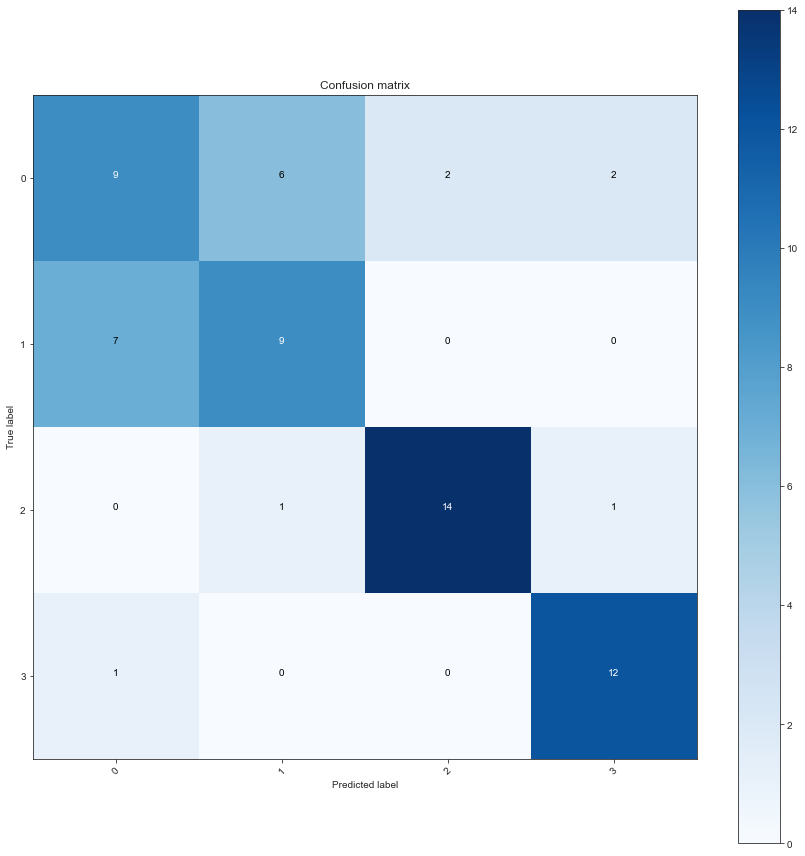

In [35]:
plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)

# plot_confusion_matrix(Ytest, 
#                       Ypred, 
#                       labels=[0,1,2,3], 
#                       title='Confusion matrix')

# confusion_matrix(Ytest, Ypred)